# Dirac notation experiments
Solve using different transient non-line-of-sight algorithms using the Dirac notation

In [1]:
import numpy as np
import tal
import src.dirac_types as dirac
import src.dirac_io as io

import matplotlib.pyplot as plt

Load the observations from the captured data. The results are:

<style>
td, th {
   border: none!important;
}
</style>

<table border="0">
 <tr>
    <td>T_mn[m, n, t] </td>
    <td> &rarr; </td>
    <td> Observations captured at the relay wall, for m sensors, with n illumination points, at time t </td>
 </tr>
 <tr>
   <td>ks[m] </td>
   <td>&rarr; </td>
   <td> Sensor at the relay wall positions</td>
 </tr>
 <tr>
   <td>offset_ks[m] </td><td>&rarr; </td><td>Distance for each sensor at the relay wall to the sensor device</td>
 </tr>
 <tr>
   <td>offset_kl[n] </td><td>&rarr; </td><td>Distance for each light source at the relay wall to the laser</td>
 </tr>
 <tr>
   <td>kt[t] &nbsp;&nbsp;</td><td>&rarr; </td><td>Time stamps for each moment k of the data</td>
 </tr>
</table>

<!-- - $ T_{mn}[m, n, t] $ &nbsp;&nbsp;&rarr;&nbsp; Observations captured at the relay wall, for m sensors, with n illumination points, at time t
- $ ks[m] $ &nbsp;&nbsp;&rarr; Sensor at the relay wall positions
- $ kl[n] $ &nbsp;&nbsp;&rarr; Light sources at the relay wall positions
- $ offset_{ks}[m] $ &rarr; Distance for each sensor at the relay wall to the sensor device
- $ offset_{kl}[n] $ &rarr; Distance for each light source at the relay wall to the laser
- $ kt[t] $ &nbsp;&nbsp;&rarr; Time stamps for each moment k of the data -->


In [2]:
T_mn_r, ks, kl, offset_ks, offset_kl, kt = io.read_observations('D:/Documentos/NLOS/nlos_dataset/mesh_R_256x256/front/data.hdf5')

Modify the data to generate a second pulse at the moment t_0

In [3]:
# Index and time stamp to pad
t_idx = np.array([0, 200])
t_0 = kt[t_idx]
pad_T_mn = lambda n: np.pad(T_mn_r, ((0,0), (0,0), (n, 0)), 'minimum')[:, :, :kt.shape[0]]
illuminated_T_mn = np.array(list(map(pad_T_mn, t_idx)))
# Combined different illuminations
T_mn = np.sum(illuminated_T_mn, axis = 0)

Plot the input data

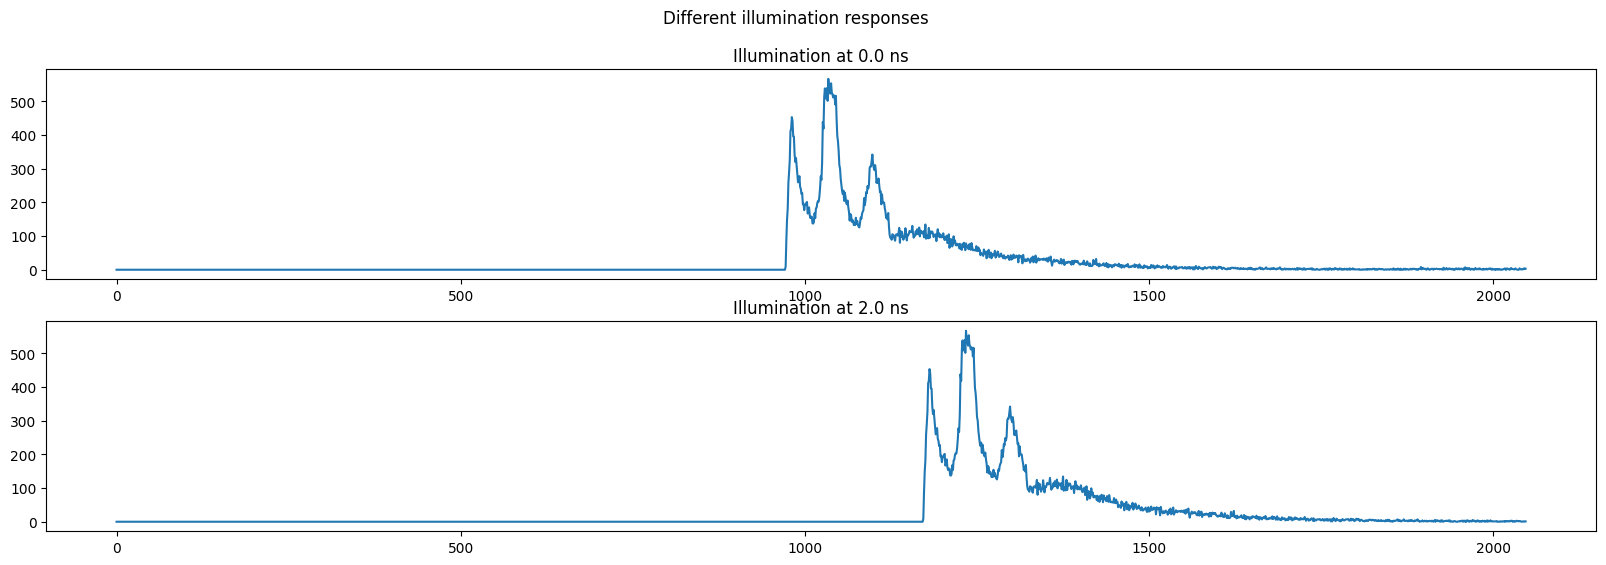

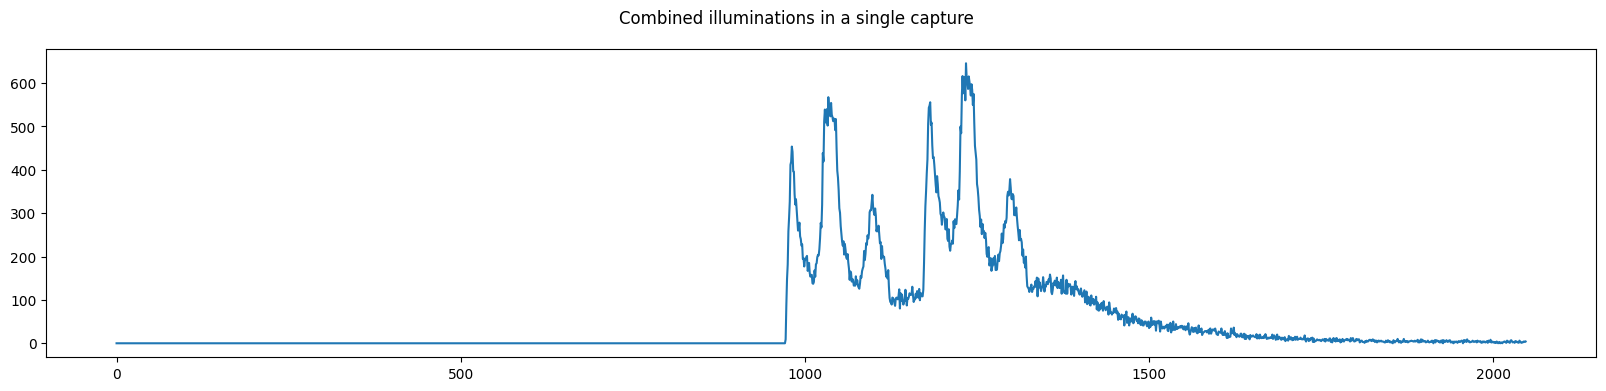

In [4]:
# Plot the different illuminations
fig, axes = plt.subplots(t_idx.shape[0], figsize=(20, 6))
fig.suptitle('Different illumination responses')
for i, T_p in enumerate(illuminated_T_mn):
    axes[i].plot(T_p[0,0])
    axes[i].set_title(f'Illumination at {t_0[i]/3e-1} ns')

# Plot combined illuminations in a single capture
fig = plt.figure(figsize=(20, 4))
fig.suptitle('Combined illuminations in a single capture')
plt.plot(T_mn[0,0])

plt.show()

## Quantum state observations
The observations are in the Real measurement. To transform them into the quantum state, it is used a change of basis.

### Illumination pulses

Delta illumination pulse:

$$ l_n (\mathbf{x}, t) = \int_\mathbb{R} d \omega'\hat{l}_n(\mathbf{x})e^{i\omega'(t-t_n^{(0)})} = \hat{l}_n(x)\mathcal{F_{\omega'}}\left(e^{i\omega' t_n^{(0)}}\right)$$

In [5]:
# Delta illumination pulse
hat_l = np.exp(1j * t_idx[:, None] * (2*np.pi) * np.fft.fftfreq(kt.shape[0]))

$$ s_m(\mathbf{x}, t) = \int_\mathbb{R} d\omega \hat{s}_m(\mathbf{x}, \omega) e^{i\omega t} $$

In [6]:
hat_s = np.fft.fft(T_mn.reshape((-1, T_mn.shape[-1])))

$$ \hat{T}_{m,n} = \Ket{\hat{s}_m} \Bra{\hat{l}_n} $$
$$ \hat{T}_{m,n}^t = \Ket{\hat{l}_n} \Bra{\hat{s}_m} $$
$$ \left(\Bra{\hat{l}_n} \hat{T}_{m,n}^t\right)^\dagger = \Ket{\hat{s}_n} $$

In [20]:
ket_s = dirac.Ket(hat_s)
ket_l = dirac.Ket(np.sum(hat_l, axis = 0)[np.newaxis, :])
T_hat_mn = np.moveaxis(dirac.dagger(ket_l * ket_s.bra()), 0,-1)

In [31]:
ket_l = dirac.Ket(np.sum(hat_l, axis = 0)[np.newaxis, :])
# ket_l = dirac.Ket(hat_l)
bra_l = ket_l.bra()
ket_s = dirac.Ket(np.fft.fft(T_mn_r.reshape(-1, 2048)))
bra_s = ket_s.bra()
T = np.moveaxis(dirac.dagger((ket_l*bra_s)), 0, -1)

## Plotting

Illumination pulses

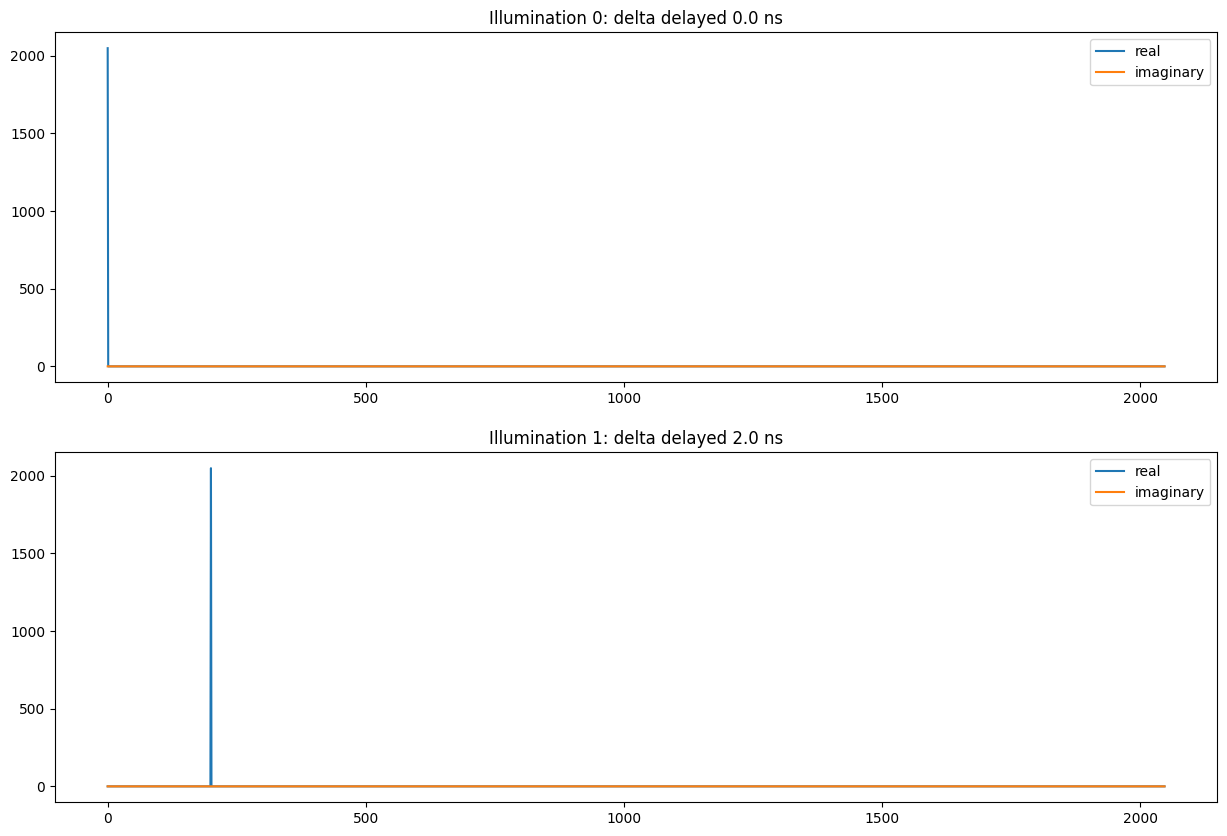

In [10]:
fig, ax = plt.subplots(t_idx.shape[0], 1, figsize=(15, 10))
for i, l in enumerate(np.fft.fft(hat_l)):
    ax[i].set_title(f'Illumination {i}: delta delayed {t_0[i]/3e-1} ns')
    ax[i].plot(np.real(l), label='real')
    ax[i].plot(np.imag(l), label='imaginary')
    ax[i].legend()

plt.show()

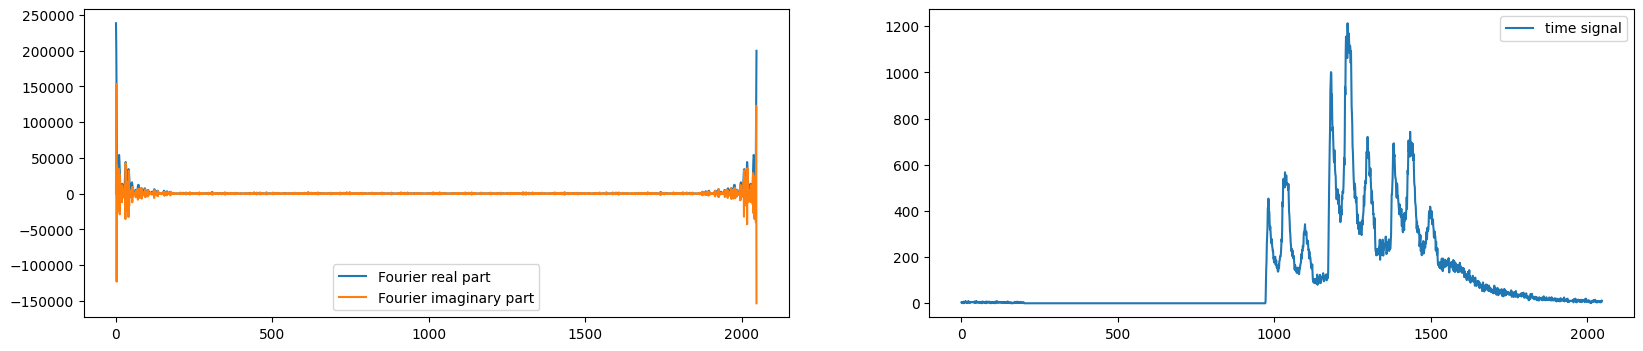

In [21]:
fig, ax = plt.subplots(T_hat_mn.shape[1], 2, figsize=(20, 4*T_hat_mn.shape[1]))
for i, t in enumerate(T_hat_mn[0]):
    if T_hat_mn.shape[1] > 1:
        axs = ax[i]
    else:
        axs = ax
    axs[0].plot(np.abs(t), label = 'Fourier real part')
    axs[0].plot(np.imag(t), label = 'Fourier imaginary part')
    axs[0].legend()
    axs[1].plot(np.real(np.fft.ifft(t)), label='time signal')
    axs[1].legend()

plt.show()

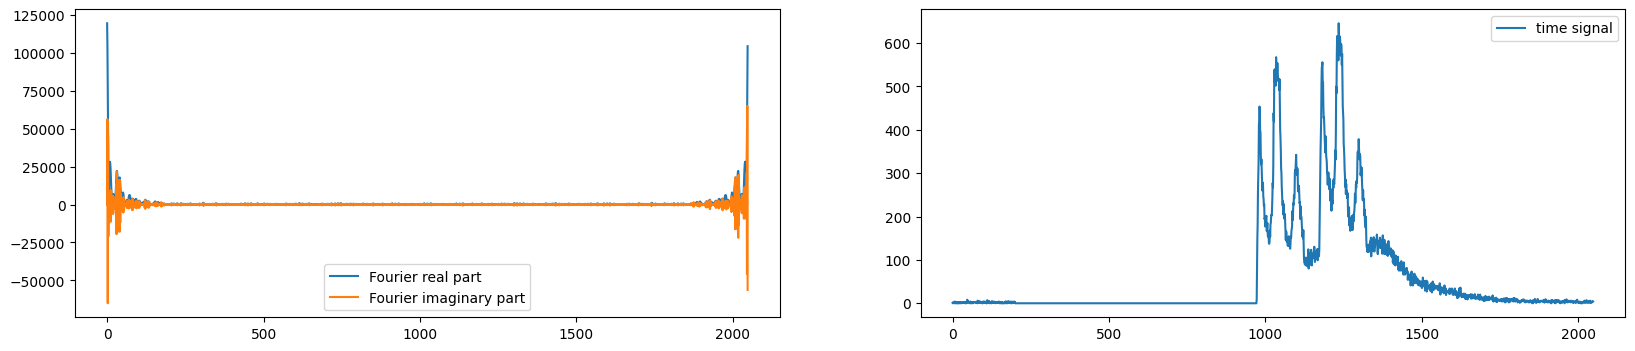

In [32]:
fig, ax = plt.subplots(T.shape[1], 2, figsize=(20, 4))
for i, t in enumerate(T[0]):
    if T.shape[1] > 1:
        axs = ax[i]
    else:
        axs = ax
    axs[0].plot(np.abs(t), label = 'Fourier real part')
    axs[0].plot(np.imag(t), label = 'Fourier imaginary part')
    axs[0].legend()
    axs[1].plot(np.real(np.fft.ifft(t)), label='time signal')
    axs[1].legend()

plt.show()

(2048, 1, 1) (2048, 1, 1)
[[[[4.        +0.j        ]
   [3.63516963+1.15161638j]
   [2.67377971+1.88308813j]
   ...
   [1.46657449-1.92755213j]
   [2.67377971-1.88308813j]
   [3.63516963-1.15161638j]]]


 [[[3.63516963-1.15161638j]
   [3.63516963+0.j        ]
   [2.97205948+0.94154407j]
   ...
   [0.7778616 -2.17397754j]
   [1.88776191-2.48112832j]
   [2.97205948-2.09316045j]]]


 [[[2.67377971-1.88308813j]
   [2.97205948-0.94154407j]
   [2.67377971+0.j        ]
   ...
   [0.07288664-1.97888469j]
   [0.90076925-2.51748141j]
   [1.88776191-2.48112832j]]]


 ...


 [[[1.46657449+1.92755213j]
   [0.7778616 +2.17397754j]
   [0.07288664+1.97888469j]
   ...
   [1.46657449+0.j        ]
   [1.88776191+0.59804019j]
   [1.88776191+1.32951194j]]]


 [[[2.67377971+1.88308813j]
   [1.88776191+2.48112832j]
   [0.90076925+2.51748141j]
   ...
   [1.88776191-0.59804019j]
   [2.67377971+0.j        ]
   [2.97205948+0.94154407j]]]


 [[[3.63516963+1.15161638j]
   [2.97205948+2.09316045j]
   [1.88776191+2

ValueError: x and y can be no greater than 2D, but have shapes (2048,) and (2048, 1, 2048, 1)

<Figure size 640x480 with 0 Axes>

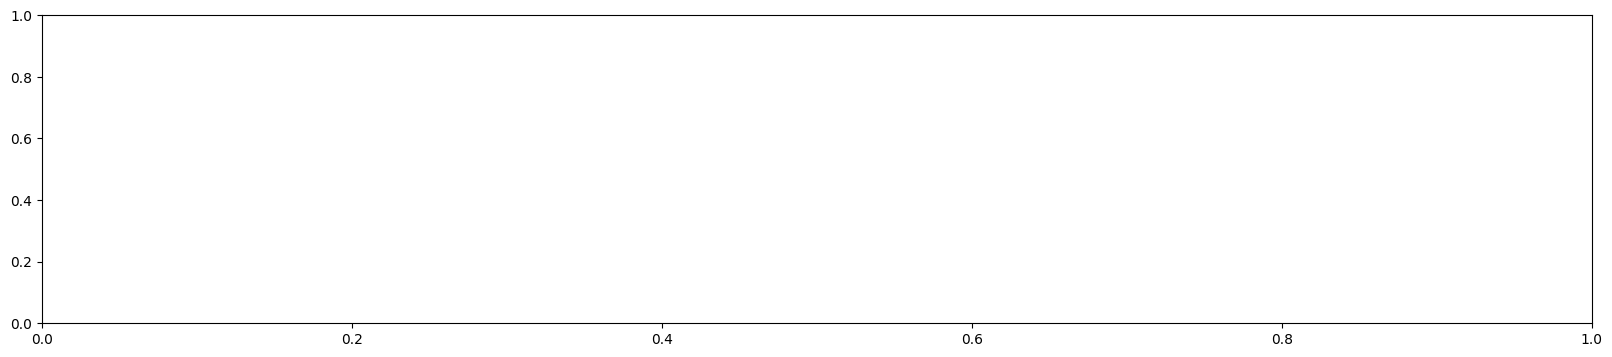

In [56]:
plt.figure()
print(bra_l.shape, ket_l.shape)
kk = np.inner(bra_l, np.conjugate(bra_l))
print(kk.shape)
fig, ax = plt.subplots(1, figsize=(20, 4))
ax.plot(np.fft.ifft(kk))
plt.show()
